Dry adiabatic lapse rate is
$$
\Gamma_d \approx 9.8 K km^{-1}.
$$
Anything **less** is stable (or **more** if the lapse rate is taken **negative**).

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from cartopy import crs
import matplotlib.pyplot as plt
from matplotlib import gridspec as gs

# import sys
# sys.path.append('/sata1_ceazalabs/arno/HPC/uvHome/code/python')
# import condor

In [2]:
import condor
condor.enable_github_import()
import helpers as hh
from data.WRF import Files
import laplace as lapl

loading helpers from github repo cezanne
loading data from github repo cezanne
loading data.WRF from github repo cezanne
loading laplace from github repo cezanne


In [5]:
%matplotlib nbagg

In [2]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png', 'pdf')

In [6]:
D = pd.HDFStore('/HPC/arno/data/station_data_new.h5')

In [8]:
sta = Files.stations()

In [10]:
s = sta[(sta.lat.astype(float)>-33) & (sta.lat.astype(float)<-28)]

In [11]:
T2 = hh.stationize(D['ta_c'].xs('prom', 1, 'aggr').drop('10', 1, level='elev'))
T = xr.DataArray(T2, dims=('time', 'space')).dropna('time', 'all').dropna('space', 'all')
Z = xr.DataArray(s['elev'].to_frame(), dims=('space', 'var')).dropna('space').astype(float)

In [12]:
si = s.index.intersection(T.space)

In [13]:
Tr = T.sel(space=si).resample('h', 'time')

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/bin/ipython:1: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="h").mean() 
  #!/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/bin/python
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [140]:
L = lapl.LRLR(s, weights=lapl.LRLR.gauss(20000))

In [141]:
L.regress(Z, Tr.sel(time='2016-06'), 0.)

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.333547258435862e-23 / 1.1102230246251565e-16
  RuntimeWarning)


In [104]:
p0 = L.p.sel(var='elev').values

In [106]:
p1 = L.p.sel(var='elev').values

In [142]:
ll = sta.loc[L.p.space][['lon', 'lat']].astype(float).as_matrix().T

In [143]:
count = Tr.sel(space=si).count('time')
count = count / count.max() * 50

In [22]:
coq = condor.Coquimbo()

<IPython.core.display.Javascript object>


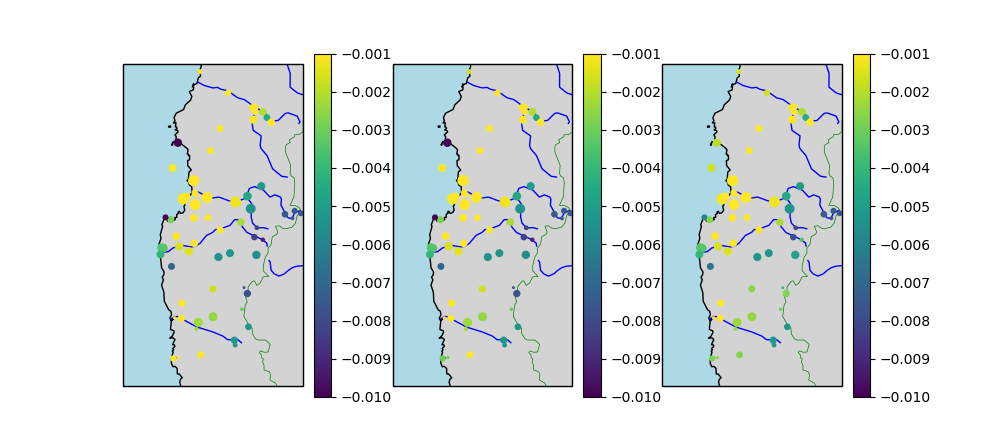

In [108]:
mi, ma = -0.01, -0.001

fig, axs = plt.subplots(1, 3, subplot_kw={'projection': crs.PlateCarree()})
plt.sca(axs[0])
plt.scatter(*ll, c=p0.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[0])

plt.sca(axs[1])
plt.scatter(*ll, c=p1.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[1])

plt.sca(axs[2])
plt.scatter(*ll, c=L.p.sel(var='elev').values.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[2])

In [22]:
from scipy.sparse import csgraph

In [145]:
%matplotlib nbagg

In [128]:
x = Tr.sel(time='2016', space=s.index[s.index.str.contains('MET')])
x.coords['hour'] = ('time', x.time.dt.hour)

In [111]:
s[s.index.str.contains('MET')]

,full,lon,lat,elev,first,last
station,,,,,,
MET3CH,Chiguinto,-70.32978,-28.83476,1063,2009-12-09 17:35:00,2017-09-24 00:00:00
MET3LA,La Arena,-70.27849,-28.91144,1209,2010-04-19 00:20:00,2017-09-24 00:00:00
MET3LH,La Huerta,-70.47333,-28.77642,872,2010-09-23 10:30:00,2017-09-24 00:00:00
MET3LM,La Mesilla,-70.43542,-28.83674,961,2009-12-09 17:45:00,2017-09-24 00:00:00
MET3LP,La Pampa,-70.22005,-28.97483,1363,2010-02-14 13:10:00,2017-09-24 00:00:00
MET3RM,Ramadilla,-70.43668,-28.77159,880,2009-12-09 17:40:00,2017-09-24 00:00:00
MET3SF,San Felix,-70.45712,-28.94014,1222,2010-01-06 12:50:00,2017-09-24 00:00:00


<IPython.core.display.Javascript object>


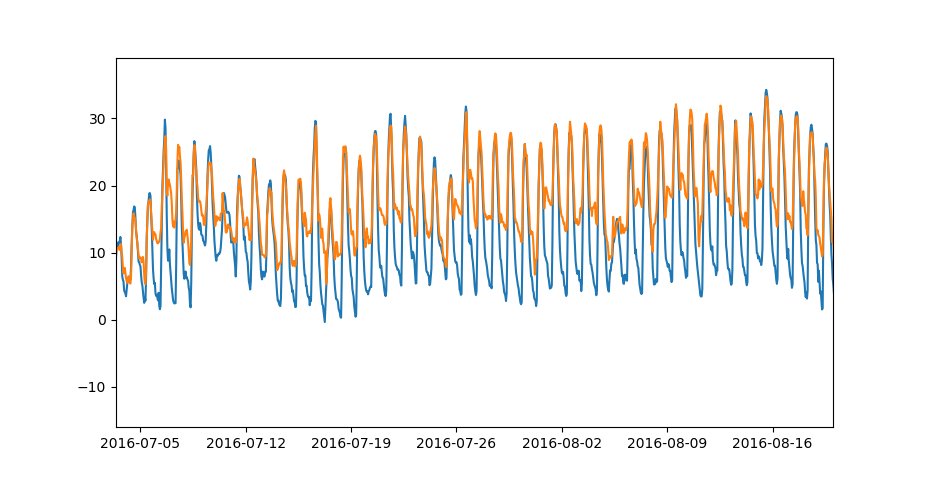

In [130]:
plt.figure()
plt.plot(x.time, x.sel(space='MET3LH').values)
plt.plot(x.time, x.sel(space='MET3CH').values)

The values of the (average) lapse rate in the Huasco value are (inverted) outliers mostly because of one station which doesn't seem to cool as much at night - **if that data is correct**.

In [10]:
x, y, r = lapl.LRLR.test(init=True)

In [11]:
r = Out[7]

In [12]:
r.p

<xarray.DataArray (time: 2, space: 2, var: 2)>
array([[[ 3.067698, -0.030556],
        [-1.038407,  1.035337]],

       [[ 0.999622,  2.003755],
        [-4.976419,  2.978723]]])
Coordinates:
  * space    (space) int64 0 1
  * var      (var) <U4 'x' 'icpt'
Dimensions without coordinates: time

In [16]:
I = np.identity(2)

In [17]:
I

array([[1., 0.],
       [0., 1.]])

In [22]:
(lambda d:d*.5+I)(1-I)

array([[1. , 0.5],
       [0.5, 1. ]])

In [79]:
ds = xr.open_dataset('/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_0.nc')

In [80]:
ds

<xarray.Dataset>
Dimensions:     (Time: 145, bottom_top: 29, start: 328, station: 80)
Coordinates:
  * Time        (Time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * station     (station) object '21' '3' '4' '5' '6' '8' '9' 'ANDA' 'BK' ...
  * bottom_top  (bottom_top) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    XTIME       (start, Time) datetime64[ns] ...
  * start       (start) datetime64[ns] 2015-05-18T20:00:00 ...
Data variables:
    T           (start, station, bottom_top, Time) float64 ...
    GP          (start, station, bottom_top, Time) float64 ...

In [10]:
145/5

29.0

In [14]:
view.run('/sata1_ceazalabs/arno/HPC/uvHome/code/python/parallel.py')

<AsyncResult: execute:finished>

In [11]:
import sys
from imp import reload
sys.path.append('/sata1_ceazalabs/arno/HPC/uvHome/code/python')
import mpicdf
from ipyparallel import Client
rc = Client(profile='mpi')
view = rc[:]
view.activate() # <- activate magics
view.block = True
# view.block = False
view.run('/sata1_ceazalabs/arno/HPC/uvHome/code/python/parallel.py')

In [15]:
%px d = mpicdf.Data('/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_10.nc', var='T', dim='start')
%px x = d.np_op({'Time': 'mean'})
tm = mpicdf.concat_np(view, 'x', 0)

In [27]:
%px x = d.np_op({'Time': 'mean'})

In [28]:
tm = mpicdf.concat_np(view, 'x', 0)

In [31]:
%px d = mpicdf.Data('/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_10.nc', var='GP', dim='start')
%px x = d.np_op({'Time': 'mean'})
gm = mpicdf.concat_np(view, 'x', 0)

In [47]:
lr = np.mean(np.diff(tm, 1, 1) / np.diff(gm, 1, 1), 0)

In [50]:
dlr = np.diff(lr, 1, 0)

<IPython.core.display.Javascript object>


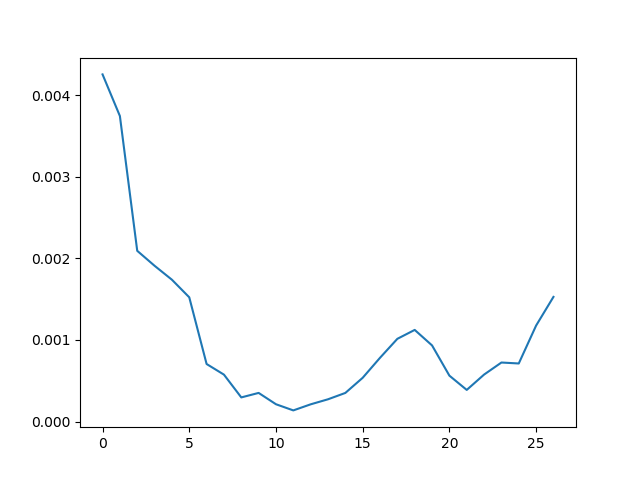

In [59]:
plt.figure()
plt.plot(np.abs(dlr.reshape((27, -1))).mean(1))

In [102]:
%px lon = d.netcdf['XLONG'][0, :, :]
lon = view['lon'][0]
%px lat = d.netcdf['XLAT'][0, :, :]
lat = view['lat'][0]

In [161]:
reload(condor)
coq = condor.Coquimbo()

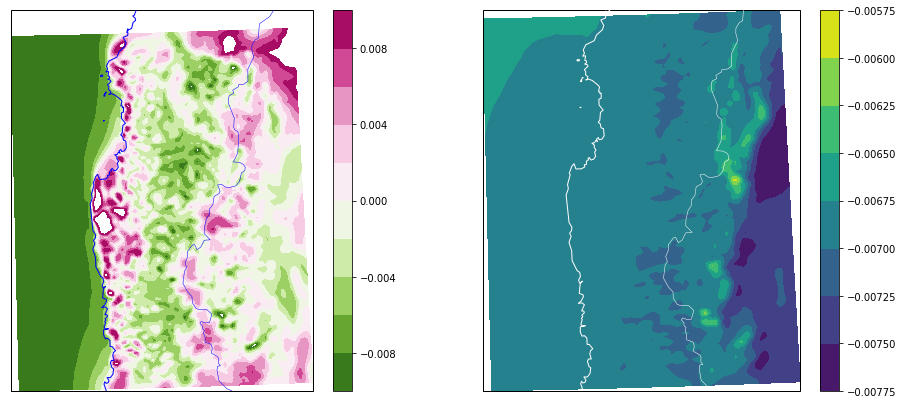

In [162]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': crs.PlateCarree()}, figsize=(16, 7))

plt.sca(axs[0])
plt.contourf(lon, lat, lr[0, :, :], np.arange(-.01, .011, .002), cmap='PiYG_r')
plt.colorbar()
coq(plt.gca(), lines_only=True, colors=['b'])

plt.sca(axs[1])
plt.contourf(lon, lat, lr[12, :, :], cmap='viridis')
plt.colorbar()
coq(plt.gca(), lines_only=True, colors=['w'])

Lapse rates as computed from the temperature differences in the lowest two layers (left) and layers 11 and 12 (right). The data are means over all WRF simulations between 2016-06-12 and 2016-08-017.

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1073852405565886e-22 / 1.1102230246251565e-16
  RuntimeWarning)


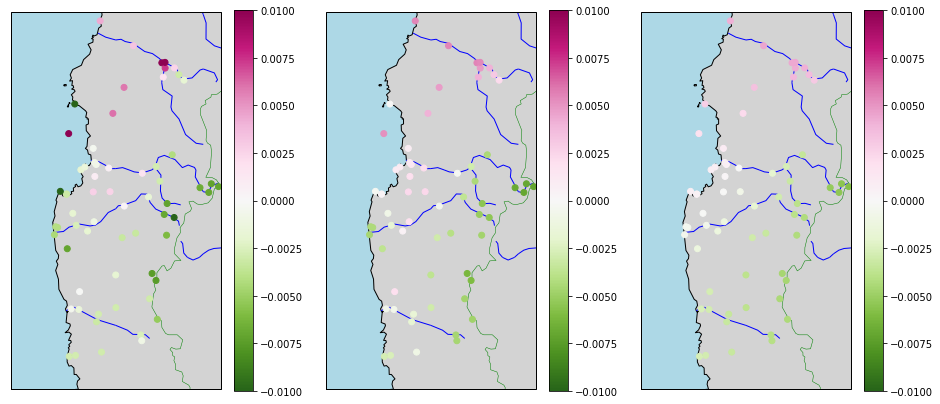

In [165]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': crs.PlateCarree()}, figsize=(16, 7))

for i, rad in enumerate([20000, 50000, 100000]):
    L = lapl.LRLR(s, weights=lapl.LRLR.gauss(rad))
    L.regress(Z, Tr.sel(time=slice('2016-06-12', '2016-08-17')), 0.)

    plt.sca(axs[i])
    plt.set_cmap('PiYG_r')
    plt.scatter(*ll, c=L.p.sel(var='elev').values.flatten(), transform=crs.PlateCarree(), vmin=-.01, vmax=.01)
    plt.colorbar()
    coq(plt.gca())

Lapse rates as a result of linear regression with distance-based weighting, using all available data (all timesteps). From left to right, the weights are a gaussian of distance with a *half width at half maximum (HWHM)* of 20, 50 and 100 km.

In [197]:
lr = (lambda x: x['T'] / x['GP'])(ds.isel(bottom_top=slice(0, 2)).diff('bottom_top').squeeze())
ll = sta.loc[lr.station][['lon', 'lat']].astype(float).as_matrix().T

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/duck_array_ops.py:127: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  flag_array = (arr1 == arr2)


In [327]:
L = lapl.LRLR(s, weights=lambda x: x*np.zeros_like(x)+np.ones_like(x))

In [188]:
a = []
for h in range(24):
    L.regress(Z, Tr.sel(time=Tr.indexes['time'].hour==h), 0.)
    a.append(L.p.sel(var='elev')[0, 0].item())

lr0 = lr.sel(start=lr.indexes['start'].hour == 20)
lr0.coords['hour'] = ('Time', lr0.Time % 24)

In [25]:
def by_hour(L, x, h):
    L.regress(Z, x.sel(time=x.indexes['time'].hour==h), 0.)
    return L.p.sel(var='elev').squeeze()

In [ ]:
b = [by_hour(L, Tr.sel(space=['LSC', 'CGR']), h)[0].item() for h in range(24)]

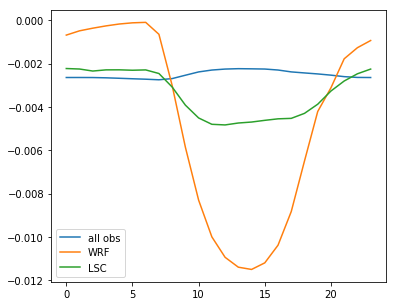

In [337]:
plt.figure(figsize=(6, 5))
plt.plot(a, label='all obs')
plt.plot(np.roll(lr0.groupby('hour').mean(), -4), label='WRF')
plt.plot(b, label='LSC')
plt.legend();

Daily cycle of lapse rates: *all obs* - using linear regression without any weighting or regularization and using all stations; *WRF* - using the difference between the two lowest model layes, interpolated to station locations and averaged; *LSC* - using unweighted linear regression only between the stations *LSC* and *CGR*.

In [343]:
L = lapl.LRLR(s, weights=lapl.LRLR.gauss(20000))
b = xr.concat([by_hour(L, Tr, h) for h in range(24)], 'hour')

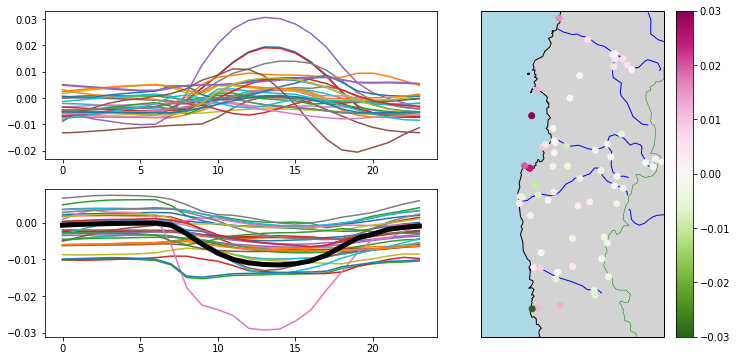

In [344]:
fig = plt.figure(figsize=(12, 6))
g = gs.GridSpec(2, 5)

l = b.sel(hour=[0, 12]).diff('hour').values > 0

plt.subplot(g[0, :3])
pl = plt.plot(b.sel(space=l.flatten()));

plt.subplot(g[1, :3], sharex=pl[0].axes)
plt.plot(b.sel(space=~l.flatten()))
plt.plot(np.roll(lr0.groupby('hour').mean(), -4), linewidth=5, color='k')

plt.subplot(g[:, 3:], projection=crs.PlateCarree())
plt.scatter(*ll, c=b.sel(hour=[0, 12]).diff('hour').values.flatten(), vmin=-.03, vmax=.03)
plt.colorbar()
coq(plt.gca())

Daily cycles of lapse rates in observations by location, computed with the gaussian weight kernel with radius 20 km.   
**Left**: The top panel shows all stations with the difference between 12h and 0h positive, the bottom panel with the same difference negative. The thick black line is the average of the WRF lapse rate (as described above).    
**Right**: The same difference (12h - 0h) plotted by station.

In [338]:
L = lapl.LRLR(s, weights=lapl.LRLR.gauss(50000))
b = xr.concat([by_hour(L, Tr, h) for h in range(24)], 'hour')

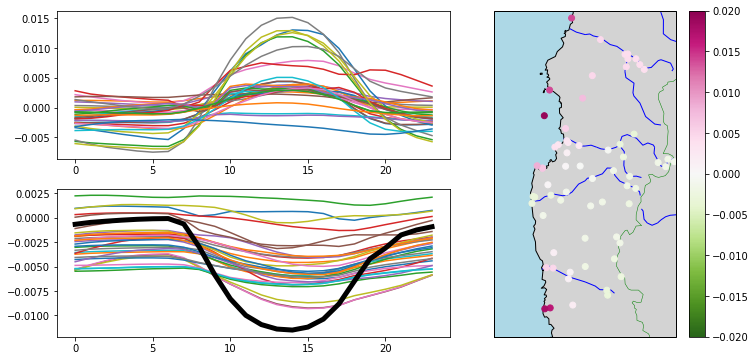

In [342]:
fig = plt.figure(figsize=(12, 6))
g = gs.GridSpec(2, 5)

l = b.sel(hour=[0, 12]).diff('hour').values > 0

plt.subplot(g[0, :3])
pl = plt.plot(b.sel(space=l.flatten()));

plt.subplot(g[1, :3], sharex=pl[0].axes)
plt.plot(b.sel(space=~l.flatten()));
plt.plot(np.roll(lr0.groupby('hour').mean(), -4), linewidth=5, color='k')

plt.subplot(g[:, 3:], projection=crs.PlateCarree())
plt.scatter(*ll, c=b.sel(hour=[0, 12]).diff('hour').values.flatten(), vmin=-.02, vmax=.02)
plt.colorbar()
coq(plt.gca())

Same plot as above, but with a 50 km gaussian weight kernel.

In [18]:
T2 = hh.stationize(D['ta_c'].xs('prom', 1, 'aggr').drop('10', 1, level='elev'))

In [14]:
import helpers as hh

loading helpers from github


In [10]:
from data.WRF import align_stations

In [15]:
ds = xr.open_dataarray('/HPC/arno/data/T2.nc')

# should work for the whole dataset independent of start hour (uses XTIME)
dt = ds - align_stations(ds, T2) - 273.15

In [158]:
dmab = xr.concat((da, db), 'start').stack(t=('start', 'Time')).mean('t')

In [145]:
dtm = dt.stack(t=('start', 'Time')).mean('t')

In [20]:
ll = sta.loc[dt.station][['lon', 'lat']].astype(float).as_matrix().T

In [168]:
xa = da.sel(station='8', Time=slice(24, 47)).stack(t=('start', 'Time')).sortby('XTIME').dropna('t')
xb = db.sel(station='8', Time=slice(24, 47)).stack(t=('start', 'Time')).sortby('XTIME').dropna('t')

In [25]:
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from scipy.stats.distributions import norm

In [59]:
k = gaussian_kde(x)

In [66]:
gm = GaussianMixture(n_components=2).fit(x.values.reshape((-1, 1)))

In [69]:
gm.fit(x.values.reshape((-1, 1)))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

<IPython.core.display.Javascript object>


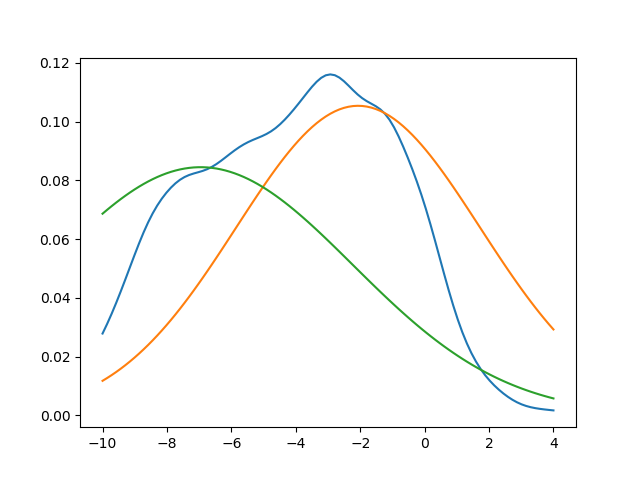

In [80]:
k = gaussian_kde(x)
gm = GaussianMixture(n_components=2).fit(x)

i = np.linspace(-10, 4, 100)
plt.figure()
plt.plot(i, k(i))
for loc, prec in zip(gm.means_.flatten(), gm.precisions_.flatten()):
    plt.plot(i, norm(loc, 1/prec).pdf(i))

In [169]:
loc, prec = [], []
for t in np.unique(xb.Time):
    gm.fit(xb.sel(Time=t).values.reshape((-1, 1)))
    loc.append(gm.means_.flatten())
    prec.append(gm.precisions_.flatten())

In [170]:
j = np.array([sorted(l) for l in loc])

In [3]:
from data.WRF import Files
from data.interpolate import GridInterpolator

loading data from github
loading data.WRF from github
loading data.interpolate from github
loading geo from github


In [7]:
ds = Files.first('d03')
gi = GridInterpolator(ds)
z = gi(ds['HGT'][0, :, :])

https://raw.githubusercontent.com/betaplane/cezanne/master/python/geo.py:235: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [39]:
%matplotlib nbagg

In [69]:
s = lambda x: x.sel(Time=slice(24, 47)).stack(t=('start', 'Time')).sortby('XTIME').dropna('station', 'all')
da = s(dt.sel(start=dt.indexes['start'].hour==20)) / z
db = s(dt.sel(start=dt.indexes['start'].hour==8)) / z

In [132]:
def gauss_mixt(x):
    loc, prec = [], []
    n = lambda s: s[np.isfinite(s)]
    for t in np.unique(x.Time):
        gm.fit(n(x.sel(Time=t).values).reshape((-1, 1)))
        loc.append(gm.means_.flatten())
        prec.append(gm.precisions_.flatten())
    return loc, prec
    return np.array(loc)[np.where(np.array([np.argsort(p) for p in prec]))]

In [130]:
la = gauss_mixt(da)
lb = gauss_mixt(db.sel(t=slice(None, pd.Timestamp('2017-04-24'))))
# lc = gauss_mixt(db.sel(t=slice(pd.Timestamp('2017-04-24'), None)))

<IPython.core.display.Javascript object>


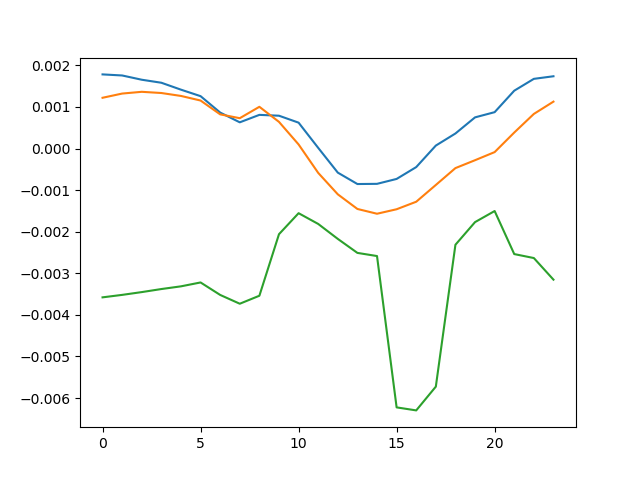

In [131]:
plt.figure()
plt.plot(np.roll(la, -4))
plt.plot(np.roll(lb, 8))
plt.plot(np.roll(lc, 8))

Daily cycles of lapse rates as devined by applying a two-distribution Gaussian mixture to the difference WRF - station data (all station data, more or less yearly periods per one of the three lines).

I think there are still errors in the data compilation from the WRF simulations, which is why the line corresponding to the last year (mid-2017 to mid-2018, green) looks so erratic. **However**, it does appear that even with the correct data from WRF (below), there is a difference in the average lapse rates between the years.

In [2]:
TGP1 = xr.open_dataset('/home/arno/code/T_GP0.nc')

In [11]:
TGP2 = xr.open_dataset('/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_0.nc')

In [8]:
lr1 = (lambda x: x['T'] / x['GP'])(TGP1[['T', 'GP']].sel(bottom_top=[0, 1]).diff('bottom_top')).squeeze()

/HPC/arno/conda/envs/uvi/lib/python3.6/site-packages/xarray/core/duck_array_ops.py:137: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  flag_array = (arr1 == arr2)


In [12]:
lr2 = (lambda x: x['T'] / x['GP'])(TGP2[['T', 'GP']].sel(bottom_top=[0, 1]).diff('bottom_top')).squeeze()

/HPC/arno/conda/envs/uvi/lib/python3.6/site-packages/xarray/core/duck_array_ops.py:137: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  flag_array = (arr1 == arr2)


<IPython.core.display.Javascript object>


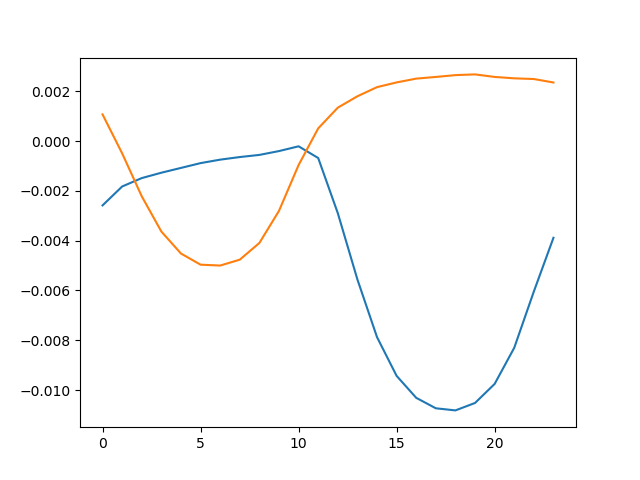

In [13]:
plt.figure()
plt.plot(lr2.sel(Time=slice(24, 47)).mean(('start', 'station')))
plt.plot(lr.sel(start=slice('2017-04-24', None), Time=slice(24, 47)).mean(('start', 'station')))

In [14]:
lr.sel(Time=slice(24, 47)).isel(start=0, station=14)

<xarray.DataArray (Time: 24)>
array([-0.013991, -0.12455 ,       nan, -0.152881, -0.16258 ,       nan,
             nan,       nan, -0.173064,       nan, -0.070299, -0.24723 ,
             nan,  0.11605 ,  0.004245,  0.006045,  0.11643 ,       nan,
       -0.170569, -0.190483,       nan,       nan,       nan, -0.233615])
Coordinates:
  * Time        (Time) int64 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 ...
    XTIME       (Time) datetime64[ns] 2016-12-02T08:00:00 ...
    start       datetime64[ns] 2016-12-01T08:00:00
    station     <U5 'CHILL'
    bottom_top  int64 1

In [17]:
np.where(TGP['T'].isel(start=100, station=10, bottom_top=[0, 1]).isnull())

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]),
 array([ 13,  16,  17,  19,  26,  28,  38,  46,  49,  50,  51,  56,  70,
         93,  96,  97,  99, 106, 108, 118, 126, 129, 130, 131, 136,   5,
         28,  31,  32,  34,  41,  43,  53,  61,  64,  65,  66,  71,  85,
        108, 111, 112, 114, 121, 123, 133, 141, 144]))

In [17]:
L = lapl.LRLR(s, weights=lapl.LRLR.gauss(20000))

In [22]:
L.regress(Z, Tr.sel(time=slice('2017-04', None)), 0.)

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.109152623547898e-24 / 1.1102230246251565e-16
  RuntimeWarning)


In [26]:
b = [by_hour(L, Tr.sel(time=slice('2017-04', None)), h)[0].item() for h in range(24)]

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.153815394235526e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.225423233738765e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.310440286592486e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3

<IPython.core.display.Javascript object>


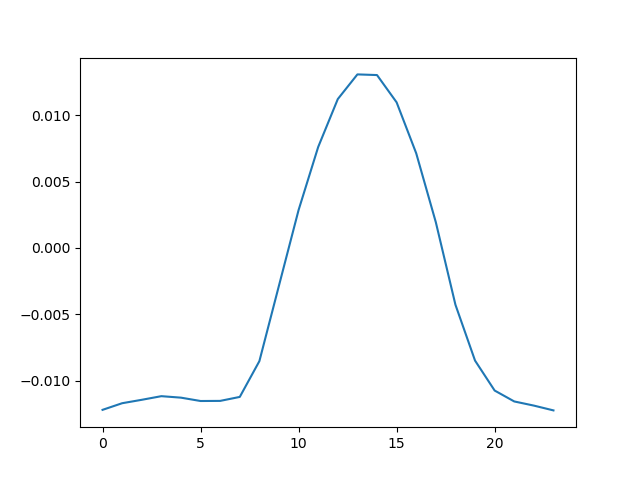

In [28]:
plt.figure()
plt.plot(b)

In [ ]:
def by_hour(L, x, h):
    L.regress(Z, x.sel(time=x.indexes['time'].hour==h), 0.)
    return L.p.sel(var='elev').squeeze()